# Errors Fitting
This notebook shows a method of determining errors in a real accelerator by modelling a virtual twin. In the real accelerator, quadrupoles are "dithered" (strength slightly varied) and the closed orbit is recorded for each quad dithering. The result is dependent on the machine errors. Then in our model, we do the same procedure and optimize over the errors in the ring, until there is agreement with the real accelerator.

We use the `Optimization.jl` package to optimize this, and in this first notebook use finite differences via `FiniteDiff.jl` to compute the closed orbit response for each quad dithering, as a first example. `GTPSA.jl`, paired with `NonlinearNormalForm.jl` can do this implicit auto-differentiation instead, which especially in an implicit AD problem will offer big performance gains. This will be detailed in a notebook to be released later.

In [1]:
using SciBmad, CairoMakie, Random, Distributions
using FiniteDiff, OptimizationLBFGSB, ADTypes
using OptimizationOptimJL

In [2]:
# FIRST GET REAL RING
include("../lattices/RCSV5S0.jl");
real_ring = ring;
real_quads = real_ring.line[findall(x->x.kind == "Quadrupole", real_ring.line)[1:2]];
real_bends = real_ring.line[findall(x->x.kind == "SBend", real_ring.line)[1:2]];
real_bpms  = real_ring.line[findall(x->x.kind == "BPM", real_ring.line)[1:2]];

In [3]:
function apply_offsets!(eles, offsets)
    @assert length(offsets) == 2*length(eles) "Length of offsets does not correspond to length of eles"
    for i in 1:length(eles)
        eles[i].x_offset = offsets[2*i-1]
        eles[i].y_offset = offsets[2*i]
    end
end

function apply_tilts!(eles, tilts)
    @assert length(tilts) == length(eles) "Length of tilts does not correspond to length of eles"
    for i in 1:length(eles)
        eles[i].tilt = tilts[i]
    end
end

apply_tilts! (generic function with 1 method)

In [4]:
# APPLY ERRORS TO REAL RING
for seed in 123:200
    Random.seed!(seed)
    quad_offset_dist = truncated(Normal(0, 200e-6), -400e-6, 400e-6)
    bpm_offset_dist =  truncated(Normal(0, 20e-6), -40e-6, 40e-6)
    bend_tilt_dist = truncated(Normal(0, 200e-6), -400e-6, 400e-6)
    
    quad_offsets = rand(quad_offset_dist, 2*length(real_quads))
    bpm_offsets = quad_offsets # NOT YET ADDING BPM ERRORS .- rand(bpm_offset_dist, 2*length(real_bpms))
    bend_tilts = rand(bend_tilt_dist, length(real_bends))
    
    apply_offsets!(real_quads, quad_offsets)
    apply_offsets!(real_bpms, bpm_offsets) 
    apply_tilts!(real_bends, bend_tilts)
    try
        co_info = find_closed_orbit(ring)
        tw = twiss(ring; co_info=co_info)
        println("success! seed=$seed, tunes=$(tw.tunes)")
        break
    catch
        continue
    end
end

# Fill known_errors with real ring errors to compare later:
known_errors = zeros(2*length(real_quads) + length(real_bends))
idx = 1
for quad in real_quads
    known_errors[idx] = quad.x_offset
    known_errors[idx+1] = quad.y_offset
    idx += 2
end
for bend in real_bends
    known_errors[idx] = bend.tilt
    idx += 1
end
known_errors

success! seed=123, tunes=(43.13105464584613, 56.21067972587314)


6-element Vector{Float64}:
 -0.00012914613442079536
 -0.0002926502757777843
 -0.00032472074911721614
 -4.353302135670924e-5
  9.844913730503657e-5
  0.00019619596242482975

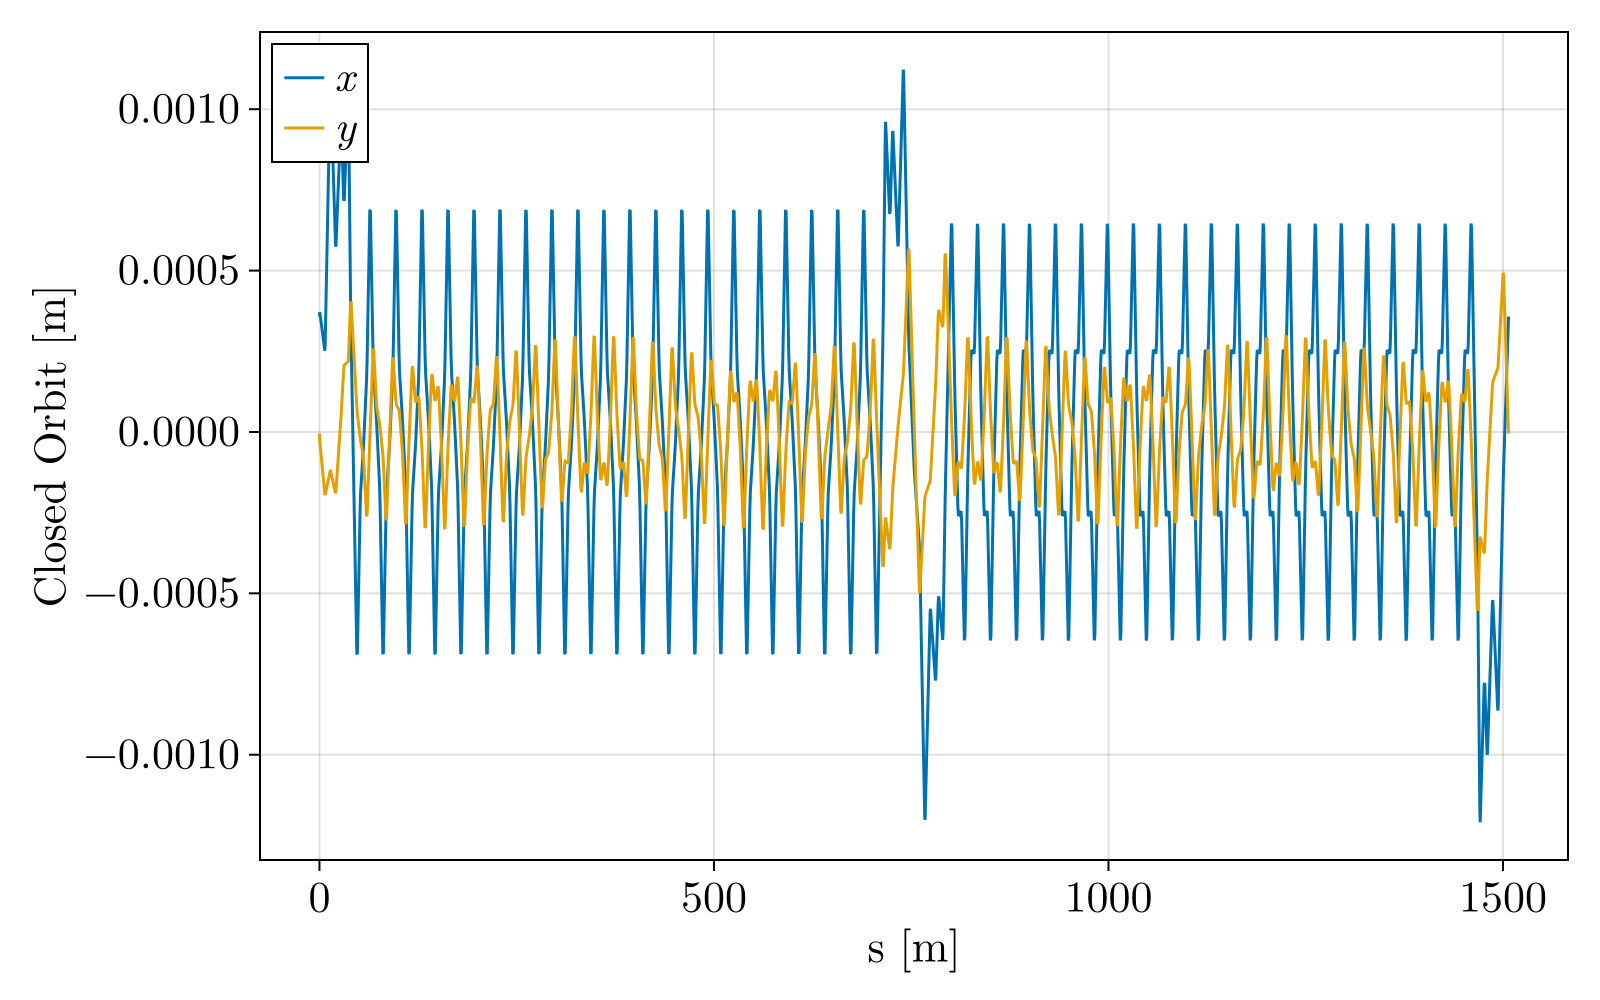

In [5]:
t = twiss(real_ring).table
# Plot the orbit around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Closed Orbit [m]");
    lines!(ax, t.s, t.orbit_x, label=L"x")
    lines!(ax, t.s, t.orbit_y, label=L"y")
    axislegend(position=:lt);
    display(f);
end;

In [6]:
function closed_orbit_meas!(orbit, lattice::Beamline, eles::Vector{Beamlines.LineElement}; v0=zeros(6))
    @assert size(orbit, 1) == length(eles) "Size of orbit array not equal to eles array"
    orbit_x = view(orbit, :, 1) #zeros(length(eles))
    orbit_y = view(orbit, :, 2) #zeros(length(eles))
    co,__ = find_closed_orbit(lattice; v0=v0, coast=Val{false}())
    
    # Track this closed orbit
    idx = 1
    b0 = Bunch(co; p_over_q_ref=lattice.p_over_q_ref, species=lattice.species_ref)
    for ele in lattice.line
        if ele in eles # If at this element, record orbit
            orbit_x[idx] = b0.coords.v[1] 
            orbit_y[idx] = b0.coords.v[3] 
            if !isnothing(ele.x_offset) # If element has offset
                orbit_x[idx] -= ele.x_offset
                orbit_y[idx] -= ele.y_offset
            end
            idx += 1
        end
        track!(b0, ele)
    end
    # One more check post loop in case last ele is BPM
    if lattice.line[end] in eles # If at this element, record orbit
        orbit_x[idx] = b0.coords.v[1] 
        orbit_y[idx] = b0.coords.v[3] 
        if !isnothing(ele.x_offset) # If element has offset
            orbit_x[idx] -= ele.x_offset
            orbit_y[idx] -= ele.y_offset
        end
    end
    return orbit
end

closed_orbit_meas! (generic function with 1 method)

In [7]:
function dither!(bpm_meas, lattice, quads, bpms; dither=0.01, v0=zeros(6))
    @assert length(bpm_meas) == length(bpms)*2*length(quads)
    bpm_meast = reshape(bpm_meas, (length(bpms), 2*length(quads)))
    for i in 1:length(quads)
        quad = quads[i]
        #print("\r Dithering quad: $i")# so $(quad.name).Kn1 = $(quad.Kn1 + dither)")
        #flush(stdout)
        quad.Kn1 += dither
        closed_orbit_meas!(view(bpm_meast, :, 2*i-1:2*i), lattice, bpms; v0=zeros(6))
        quad.Kn1 -= dither
    end
    return bpm_meas
end

dither! (generic function with 1 method)

In [8]:
# Here compute the "real" matrix containing the BPM measurements
real_bpm_meas = reshape(zeros(length(real_bpms), 2*length(real_quads)), length(real_bpms)*2*length(real_quads))
dither!(real_bpm_meas, real_ring, real_quads, real_bpms);

In [9]:
# let errors be big array sorted as 
# [x_offset[1], y_offset[1], x_offset[2], ..., y_offset[n_quads], tilt[1], ..., tilt[n_dipoles]]
function dither_objective(errors, p)
    ring = p[1]
    quads = p[2]
    bpms = p[3]
    bends = p[4]
    real_bpm_meas = p[5]
    res = p[6]
    weight = p[7]
    # Apply errors
    apply_offsets!(quads, view(errors, 1:2*length(quads)))
    # Assume BPMs are aligned with quads in our model:
    apply_offsets!(bpms, view(errors, 1:2*length(quads)))
    apply_tilts!(bends, view(errors, (2*length(quads)+1):(2*length(quads)+length(bends))))

    # Compute dithering residual
    dither!(res, ring, quads, bpms)
    res .= weight .*(res .- real_bpm_meas)
    
    #apply_offsets!(quads, zeros(2*length(quads)))
    # Assume BPMs are aligned with quads in our model:
    #apply_offsets!(bpms, zeros(2*length(quads)))
    #apply_tilts!(bends, zeros(length(bends)))
    return sum(abs2, res) # Sum of squares
end

dither_objective (generic function with 1 method)

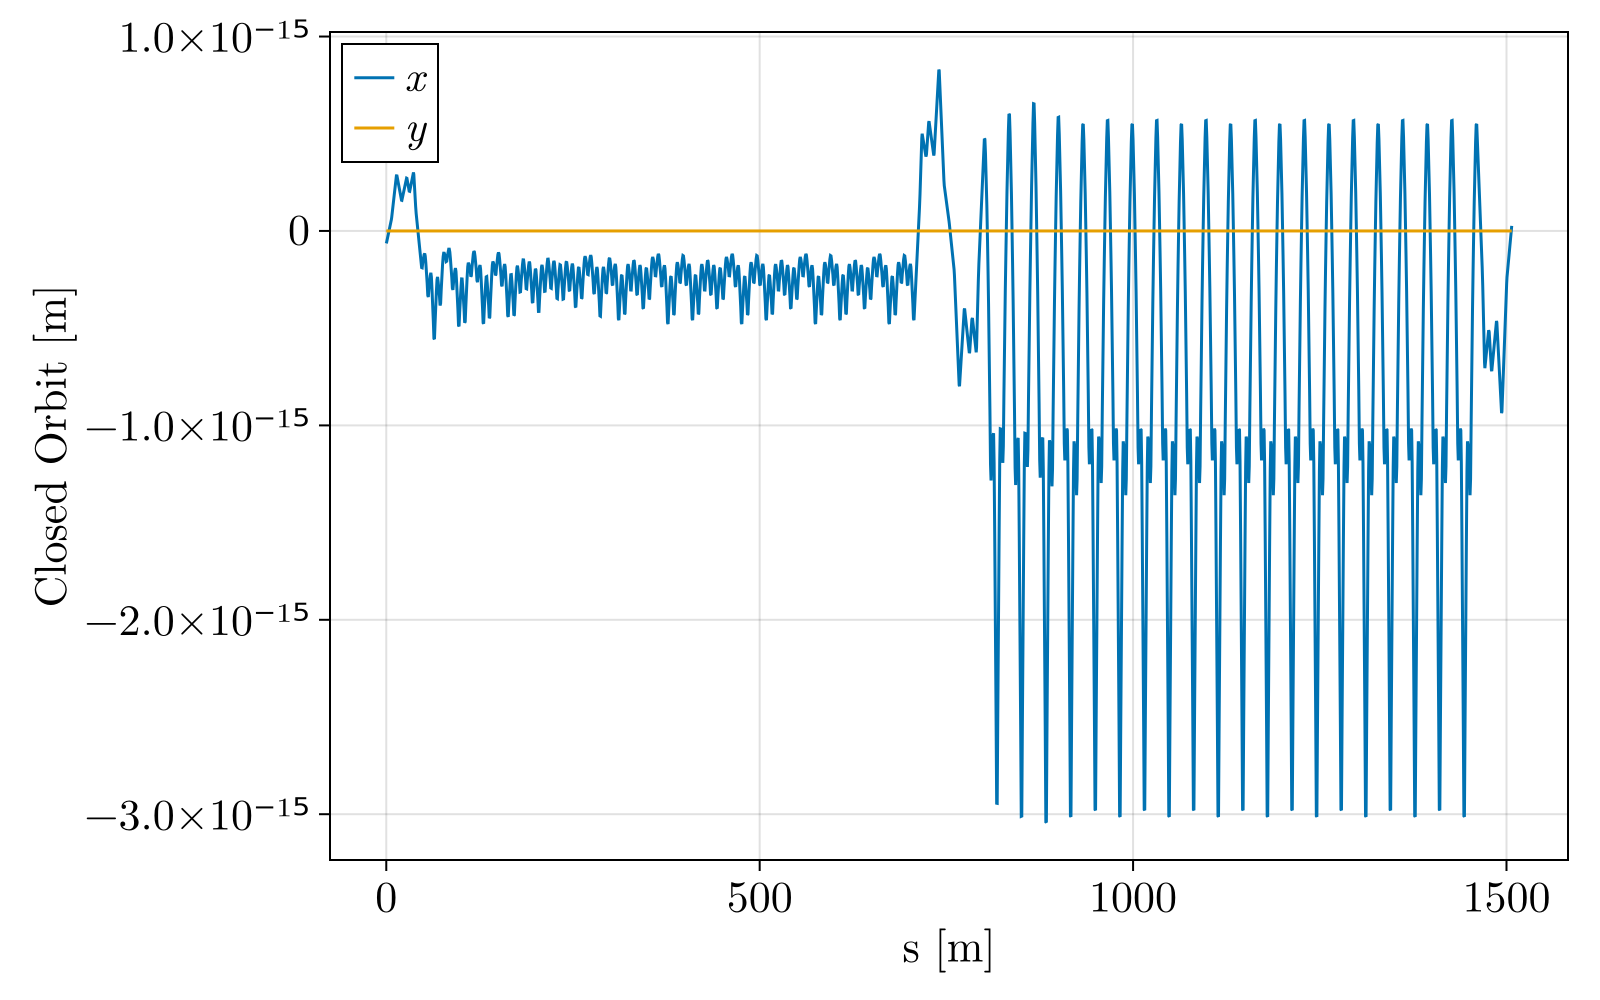

In [10]:
# NOW OUR MODEL
include("../lattices/RCSV5S0.jl");
model_ring = ring;
model_quads = model_ring.line[findall(x->x.kind == "Quadrupole", model_ring.line)[1:2]];
model_bends = model_ring.line[findall(x->x.kind == "SBend", model_ring.line)[1:2]];
model_bpms = model_ring.line[findall(x->x.kind == "BPM", model_ring.line)[1:2]];

res = rand(length(real_bpms)*2*length(real_quads)) #, length(real_bpms)*2*length(real_quads))
errors = zeros(2*length(real_quads) + length(real_bends))

p = (model_ring, model_quads, model_bpms, model_bends, real_bpm_meas, res, 10000)

tm = twiss(model_ring).table
# Plot the orbit around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Closed Orbit [m]");
    lines!(ax, tm.s, tm.orbit_x, label=L"x")
    lines!(ax, tm.s, tm.orbit_y, label=L"y")
    axislegend(position=:lt);
    display(f);
end;

In [11]:
# Good now can use optimization package
optf = OptimizationFunction(dither_objective, AutoFiniteDiff())
prob = OptimizationProblem(optf, zero(errors), p; lb=-400e-6.*ones(length(errors)), ub=400e-6.*ones(length(errors)))
callback = (state, loss_val) -> (print("\r Current solution = $(state.u), Objective = $(state.objective)"); flush(stdout); false)
sol = solve(prob, OptimizationLBFGSB.LBFGSB(), reltol=1e-16, callback=callback)

 Current solution = [-0.00012975940386160457, -0.00029311914621242855, -0.00032521701934175773, -4.491551024571448e-5, 0.0001287150885748502, 0.00012951485874563], Objective = 9.32912485326002e-6e-666582

retcode: Success
u: 6-element Vector{Float64}:
 -0.00012975940386160457
 -0.00029311914621242855
 -0.00032521701934175773
 -4.491551024571448e-5
  0.0001287150885748502
  0.00012951485874563

In [12]:
known_errors

6-element Vector{Float64}:
 -0.00012914613442079536
 -0.0002926502757777843
 -0.00032472074911721614
 -4.353302135670924e-5
  9.844913730503657e-5
  0.00019619596242482975

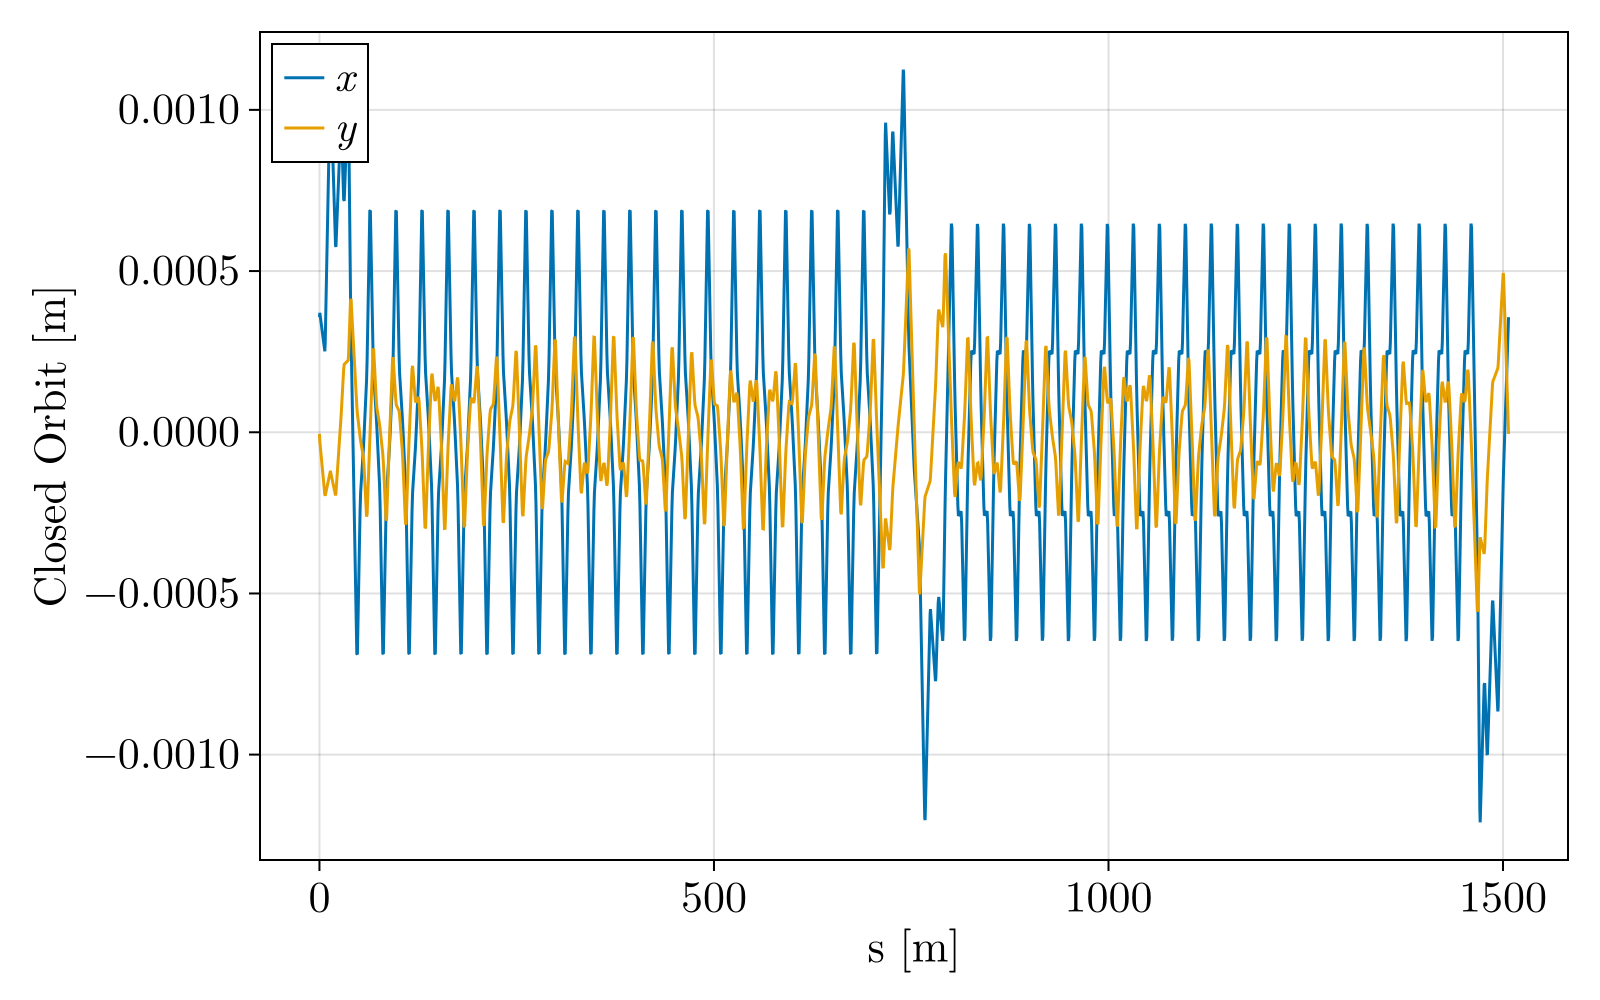

In [13]:
tm = twiss(model_ring).table
# Plot the orbit around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Closed Orbit [m]");
    lines!(ax, tm.s, tm.orbit_x, label=L"x")
    lines!(ax, tm.s, tm.orbit_y, label=L"y")
    axislegend(position=:lt);
    display(f);
end;

In [14]:
tm.orbit_x .- t.orbit_x

5388-element Vector{Float64}:
 -8.005740752989278e-7
 -7.79924724249011e-7
 -7.765997821926828e-7
 -7.753907123539145e-7
 -7.730934796604553e-7
 -7.57556932233722e-7
 -7.552596995402628e-7
 -4.0057906237130503e-7
 -3.9725412031497683e-7
 -3.624728379081582e-7
 -3.575787351154237e-7
 -3.557990613726309e-7
 -3.5241768126128116e-7
  ⋮
 -2.656785949958513e-6
 -1.0547951950690875e-6
 -1.0397773850266733e-6
 -9.699956646107874e-7
 -9.685235970883024e-7
 -9.679882998074086e-7
 -9.669712349736888e-7
 -9.600926649140764e-7
 -9.590756000803566e-7
 -8.020461427272769e-7
 -8.005740752047648e-7
 -8.005740752047648e-7